# Singapore's Best Mobile Phone Plans
This week, I'm taking a break from the HDB resale flat pricing model and turning my attention to a hotter topic: mobile phone plans.  
  
## Context
This week, some of my colleagues noted an arbitrage opportunity in Singtel's offer for the iPhone XS / XS Max on its Combo 12 plan. The idea was to:  
  
1. Re-contract (or sign a new contract) on Singtel Combo 12 to get a free iPhone XS / XS Max (Singtel now charges \$418++)  
2. Sell the phone for approximately \$1,800  
3. Pay the monthly bill of \$167.90 for Combo 12  (with a Corporate Individual Scheme [CIS] discount of 30%)  
4. Repeat every 6 months
  
The 6-months cycle in table form:
  
|  Month  |  Income |              Expenditure             |   Profit   | Remarks                                                 |
|:-------:|:-------:|:------------------------------------:|:----------:|---------------------------------------------------------|
|    1    | \$1,800 | \\$167.90 + \\$500 + \\$418 = \\$1087.90 | \\$1,132.10 | Re-contract on Combo 12, get a free iPhone, and sell it |
|    2    |    -    |               \$167.90               |  -\$167.90 | Pay Combo 12 bill                                       |
|    3    |    -    |               \$167.90               |  -\$167.90 | Pay Combo 12 bill                                       |
|    4    |    -    |               \$167.90               |  -\$167.90 | Pay Combo 12 bill                                       |
|    5    |    -    |               \$167.90               |  -\$167.90 | Pay Combo 12 bill                                       |
|    6    |    -    |               \$167.90               |  -\$167.90 | Pay Combo 12 bill                                       |
|  Total  | \$1,800 |              \$1,927.40              |  -\$127.40 |                                                         |
| Average |   \$300 |               \$321.23               |  -\$21.23  |                                                         |  
  
By repeating this *forever*, one can pay an average monthly bill of \$21.23 for Combo 12 perks. Of course, this means that you would be stuck with Singtel for as long as you want to enjoy the benefits, and that you'll eventually need to pay a full 24 months' worth of Combo 12 bills (or terminate your contract) to downgrade your plan. Nevertheless, you stand to gain from lower bills for more services assuming the following conditions hold:  
  
1. Singtel continues to offer the iPhone (the only phone with high resale value) at a low, stable price when signing up for the Combo 12 plan
2. The Combo 12 plan continues to exist, and stays at the same price
3. The resale value of the iPhone remains sufficiently high
4. Apple comes up with a new model every year
5. The CIS discount remains at 30% or better
  
Based on these assumptions, the deal was too risky for me, and I chose not to pursue it. After realising that the Singtel deal turned sour when Singtel increased the price for the iPhone XS on Combo 12 from \\$0 to \\$418, I was relieved that I hadn't jumped in. A colleague instead suggested that perhaps, I could do some analysis on the best mobile phone plan currently on offer. Hence, in this post, I do exactly that: I explore the determinants of mobile phone plan prices and outline an objective way to choose an ideal phone plan.

In [1]:
# Import required modules
from IPython.display import Image  
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydea
import pydotplus
from scipy.spatial import ConvexHull
import seaborn.apionly as sns
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from statsmodels.graphics.gofplots import qqplot
from statsmodels.regression.linear_model import OLS, add_constant
import warnings

# Settings
%matplotlib inline
warnings.filterwarnings('ignore')

# The Data
I collected mobile phone plan data from the websites of Singtel, Starhub, M1, and Circles.Life. Specifically, I looked at postpaid mobile plans that were not restricted to any age group. I saved the monthly price, free talktime (in minutes), free SMS/MMS, data (in GB), provider, length of contract (in months), and whether or not the plan was a SIM-only plan. There were a total of 48 plans.  
  
Note that the maximum amount of talktime and SMS/MMS were 10,000 minutes and 10,000 respectively as per the Telcos' policies for unlimited talktime and SMS/MMS. The maximum amount of data was assumed to be 1,000 GB, although there was no cap on data in M1's policy. 

In [3]:
# Read data
mobile = pd.read_csv('mobile_plan_data.csv')

# Remove unused columns
mobile = mobile.drop(['perk', 'perk_value'], axis = 1)

# Adjust "unlimited" figures
mobile['talktime'][mobile.talktime == 43200] = 10000
mobile['sms'][mobile.sms == 260000] = 10000
mobile['data'][mobile.data == 999999] = 1000

# Preview
mobile.groupby('provider').head(2)

name  price  talktime  sms  data      provider  contract sim_only
0       simonly10  36.05       150  500  12.0       singtel        12     True
1        simonly5  20.00       150  500   6.0       singtel        12     True
9        xs_sim12  24.00       200    0   9.0       starhub        12     True
10        s_sim12  34.00       400    0  11.0       starhub        12     True
27  mysim20_12mth  20.00       100  100   5.0            m1        12     True
28  mysim40_12mth  40.00       100  100  15.0            m1        12     True
45    data_baller  48.00       100    0  26.0  circles_life         0     True
46     sweet_spot  28.00       100    0   6.0  circles_life         0     True

# Exploring the Data
First, we explore the distributions of the various features. We note that most of the features were not normally distributed. Hence, we applied the log transformation to all numeric features, less the contract length, which we convert into a categorical feature.

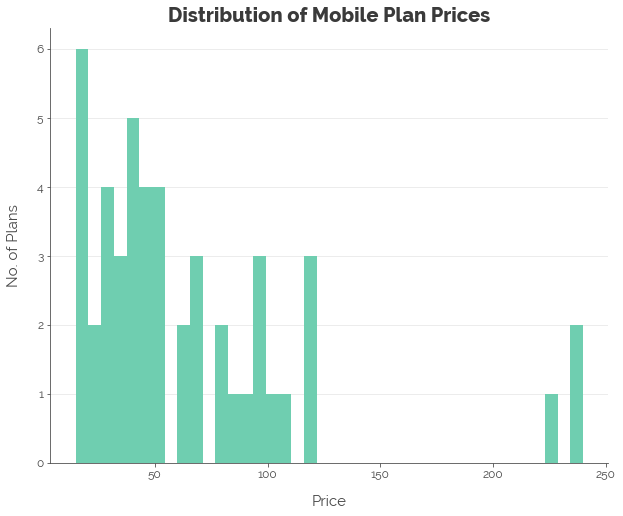

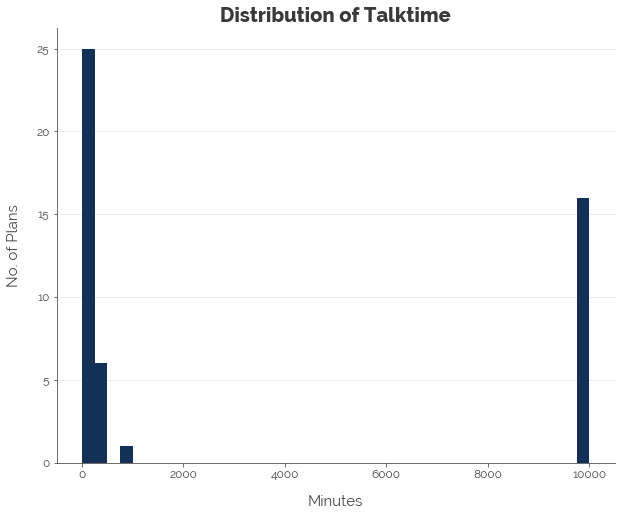

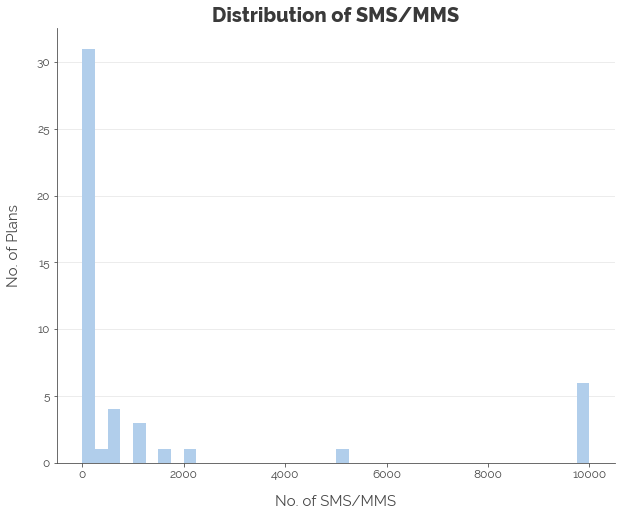

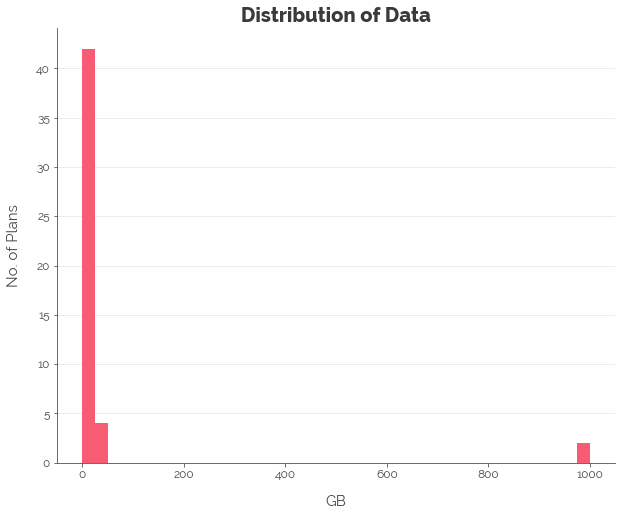

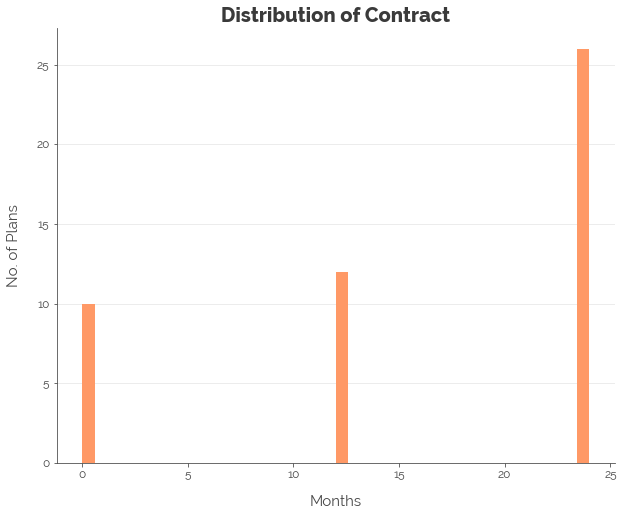

In [4]:
# CODE FOR CUSTOM GRAPHICS NOT INCLUDED

# Linear Regression: Quantifying Linear Relationships
Using Starhub and 24-month contracts as the reference categories for the service provider and contract features respectively, we obtain a regression with an adjusted R-squared value of **76%**. Here are the findings:  
  
1. A **1.00% increase** in free talktime corresponds to a **0.18% increase** in price.
2. A **1.00% increase** in number of free SMS/MMS corresponds to a **0.07% *decrease*** in price (or simply negligible).
3. A **1.00% increase** in data corresponds to a **0.16% increase** in price.
4. A **SIM-only plan** is **0.69% cheaper** than a full mobile plan.
5. M1 and Singtel plans are respectively **0.51% and 0.54% more expensive** than Starhub plans. Starhub plans and Circle.Life plans are competitively priced.
6. There is **no significant difference in price** for plans with 24-month contracts, 12-month contracts, and plans without contracts.

In [5]:
# Configure features to use
feats = ['talktime', 'sms', 'data', 'provider', 'contract', 'sim_only']

# Extract data
y_data = np.log(mobile['price'])
X_data = mobile[feats]

# Convert contract to categorical
X_data.contract = X_data.contract.astype(str)

# Get dummy features
X_data = pd.get_dummies(X_data)

# Take logs
X_data.talktime[X_data.talktime == 0] = 1
X_data.talktime = np.log(X_data.talktime)
X_data.sms[X_data.sms == 0] = 1
X_data.sms = np.log(X_data.sms)
X_data.data = np.log(X_data.data)

# Make starhub and 24-month contracts the reference categories
X_data = X_data.drop(['provider_starhub', 'contract_24'], axis = 1)

# Fit linear regression model
lm_mobile = OLS(y_data, add_constant(X_data.astype(float)))
lm_results = lm_mobile.fit()
print(lm_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     18.23
Date:                Sat, 29 Sep 2018   Prob (F-statistic):           3.09e-11
Time:                        22:57:43   Log-Likelihood:                -9.8884
No. Observations:                  48   AIC:                             39.78
Df Residuals:                      38   BIC:                             58.49
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.74

A Q-Q plot of the residuals suggests that our data transformations have worked: the assumption of normality of the residuals for our model is satisfied.

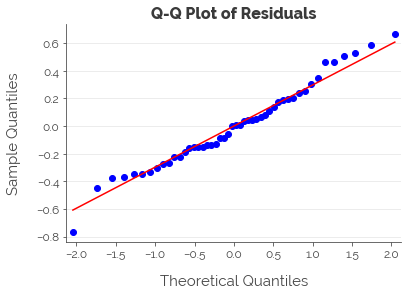

In [6]:
# Residual plot
qqplot(lm_results.resid, line = 's')

# CODE FOR CUSTOM GRAPHICS NOT INCLUDED

# Decision Trees: Quantifying Non-Linear Relationships
Another way to view the problem is through a non-linear lens. That is, we use a decision tree to (1) establish rules on how to segregate the data and (2) identify the important features. We create a decision tree with a maximum depth of 3 (to avoid overfitting), and obtain the decision tree plotted below, which has an R-squared of **83%**.

0.8313318671838421


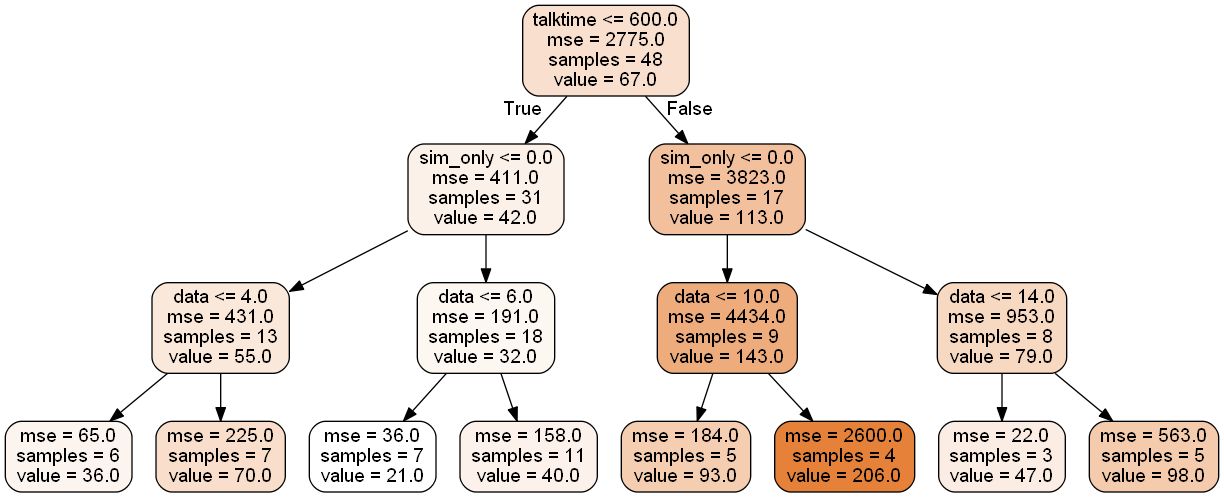

In [7]:
# Get data
y_data = mobile['price']
X_data = mobile[feats]
X_data = pd.get_dummies(X_data)

# Decision tree
tree_mobile = DecisionTreeRegressor(max_depth = 3)
tree_mobile.fit(X_data, y_data)

# Plot
dot_data = tree.export_graphviz(
    tree_mobile, feature_names = X_data.columns,
    out_file=None, filled=True,
    rounded=True, precision = 0
)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# NOT RUN - compute adjusted R-squared
yhat = tree_mobile.predict(X_data)
SS_Residual = sum((y_data-yhat)**2)
SS_Total = sum((y_data-np.mean(y_data))**2)
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1 - (1-r_squared)*(len(y_data)-1)/(len(y_data)-X_data.shape[1]-1)
print(adjusted_r_squared)

# Show graph
Image(graph.create_png(), width = 1000)

Examining the feature importances, we see that the only three things that matter are (1) talktime, (2) data, and (3) whether or not the plan is SIM-only, in that order.

In [8]:
# Extract coefficients
tree_impt = pd.DataFrame(tree_mobile.feature_importances_)
tree_impt['Feature'] = X_data.columns
tree_impt = tree_impt.rename(columns = {0: 'Importance'})

# View feature importances
tree_impt

Importance                Feature
0    0.482157               talktime
1    0.000000                    sms
2    0.333866                   data
3    0.000000               contract
4    0.183976               sim_only
5    0.000000  provider_circles_life
6    0.000000            provider_m1
7    0.000000       provider_singtel
8    0.000000       provider_starhub

# Data Envelopment Analysis: Identifying the Most Worthwhile Plans
Thus far, we've looked at the most important determinants of price. The linear regression and decision tree models generally concur: the amount of talktime, amount of data, and whether the plan was SIM-only were the things that mattered most. Yet, all these insights are not actionable unless we come up with a hierarchy of the most worthwhile mobile plans. Hence, this is what we aim to do next through Data Envelopment Analysis (DEA).  
  
## DEA?
DEA is a way to compare the efficiency of different business units. Although each business unit uses several inputs and outputs, DEA allows us to combine them into a single score. Then, we can use these scores to rank the various business units.
  
In this case, we can think of the outputs as talktime and data, and the sole input as cost. We can easily change the inputs and outputs to whatever is important to us. For example, we could add SMS/MMS as an output if we text a lot, and the contract time as an input because contracts tie us down to a single provider. For now, we calculate the efficiency scores for the mobile plans using talktime per dollar and data (in GB) per dollar.

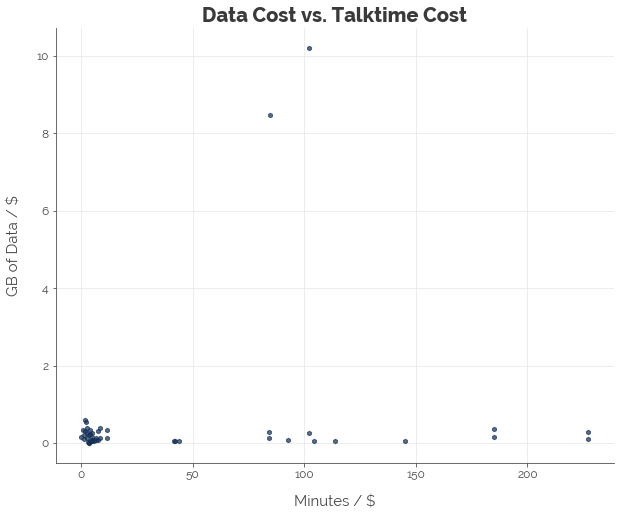

In [9]:
# Extract data
df = mobile[['price', 'talktime', 'data']]

# Calculate efficiency scores
df['talktime_cost'] = df.talktime / df.price
df['data_cost'] = df.data / df.price

# CODE FOR CUSTOM GRAPHICS NOT INCLUDED

Next, we want to know which plans give us the best value for our money. These plans have either: (1) the most data per dollar, (2) the most talktime per dollar, or some combination of both. To do that, we only need the outermost points of the graph above. Thus, we compute the convex hull and draw a line around the outermost points. This is the efficient frontier.

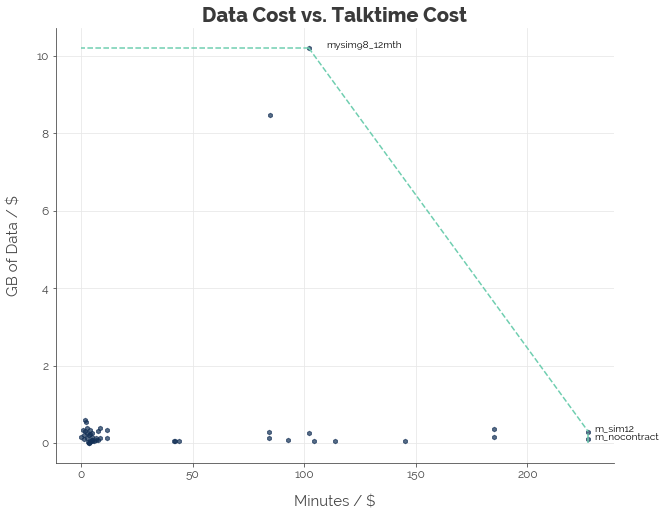

In [10]:
# Extract efficiencies
eff_data = df[['talktime_cost', 'data_cost']].copy()

# Compute convex hull
hull = ConvexHull(eff_data)

# CODE FOR CUSTOM GRAPHICS NOT INCLUDED

Graphically, we can see which plans are the most efficient. The three "most efficient" plans are:  
  
* M1's mySIM 98 SIM-only 12-month plan that costs \$98.00 (if you prefer data)
* Starhub's "M" SIM-only 12-month plan that costs \$44.00 (if you prefer talktime and you are okay with a contract)
* Starhub's "M" SIM-only no-contract plan that costs \$44.00 (if you prefer talktime and you are okay to pay for freedom with less data)
  
Any plan that lies along the green line (frontier) is considered as good as the three optimal plans. All plans that lie inside the frontier are inferior. Let's put it this way. If data is important to you, there is no better plan than M1's mySIM 98. If talktime is important to you, there is no better plan than Starhub's "M" SIM-only 12-month plan. If you want a balance of both, the tradeoff between talktime and data must follow the relationship indicated by the downward-sloping line.
  
Next, we do the math using the `pyDEA` package to arrive at the same conclusions and tease out more information: we get a ranking of the most efficient mobile plans, evaluated using talktime and data as outputs and price as the sole input.

## All Plans
First, we perform the analysis for all plans. We divide each feature by the respective means (mean normalisation) to prevent the magnitude of each feature from distorting the efficiency scores. Then, we run the DEA algorithm (essentially a linear programme) to get the scores. The top 10 efficient plans are given below. The top 3 plans are the same as the ones derived using the graphical method. However, we also obtain the next best plans.

In [11]:
# Extract relevant data
df = mobile[['price', 'talktime', 'data']]
df = df / df.mean()

# Configure inputs and outputs
df_inputs = df[['price']]
df_outputs = df[['talktime', 'data']]

# Configure problem
mobile_prob = pydea.DEAProblem(df_inputs, df_outputs, returns = 'CRS')

# Solve problem
results = mobile_prob.solve()

# Attach results
dea_data = mobile[['name', 'provider', 'price', 'talktime', 'data']].copy()
dea_data['efficiency'] = round(results['Efficiency'], 3)

# Sort by efficiency
dea_data.sorted = dea_data.sort_values(by = ['efficiency', 'price', 'data'], ascending = [False, True, False])
dea_data.sorted = dea_data.sorted.reset_index(drop = True)

# Save
top_plans = dea_data.sorted.copy()

# View data
dea_data.sorted.head(10)

name provider  price  talktime    data  efficiency
0        m_sim12  starhub   44.0     10000    13.0       1.000
1   m_nocontract  starhub   44.0     10000     5.0       1.000
2  mysim98_12mth       m1   98.0     10000  1000.0       1.000
3     mysim_e118       m1  118.0     10000  1000.0       0.831
4        l_sim12  starhub   54.0     10000    19.0       0.821
5   l_nocontract  starhub   54.0     10000     8.0       0.815
6         combo3  singtel   68.9     10000     3.0       0.639
7              m  starhub   88.0     10000     5.0       0.500
8         combo6  singtel   95.9     10000     6.0       0.459
9        mysim98       m1   98.0     10000    25.0       0.456

## All Plans, Less M1's Unlimited Data Plans
M1's data plans looked good because I set a high cap on data of 1,000 GB. However, lowering the cap will not change the results: M1's plan offer good value. And because they offer good value, they are also pretty expensive. For most of us who would not pay that much for unlimited data, I perform the analysis on all plans less M1's two unlimited data plans.

In [12]:
# Extract relevant data
df = mobile[['price', 'talktime', 'data']]
df = df.drop([30, 38], axis = 0)

# Graph data
df_graph = df.copy()
df_graph['talktime_cost'] = df_graph.talktime / df_graph.price
df_graph['data_cost'] = df_graph.data / df_graph.price

# Mean normalisation
df = df / df.mean()

# Configure inputs and outputs
df_inputs = df[['price']]
df_outputs = df[['talktime', 'data']]

# Configure problem
mobile_prob = pydea.DEAProblem(df_inputs, df_outputs, returns = 'CRS')

# Solve problem
results = mobile_prob.solve()

# Attach results
dea_data = mobile[['name', 'provider', 'price', 'talktime', 'data']].copy()
dea_data['efficiency'] = round(results['Efficiency'], 3)

# Sort by efficiency
dea_data.sorted = dea_data.sort_values(by = ['efficiency', 'price', 'data'], ascending = [False, True, False])
dea_data.sorted = dea_data.sorted.reset_index(drop = True)

# View data
dea_data.sorted.head(10)

name      provider  price  talktime  data  efficiency
0        m_sim12       starhub   44.0     10000  13.0       1.000
1   m_nocontract       starhub   44.0     10000   5.0       1.000
2  mysim50_12mth            m1   50.0       100  30.0       1.000
3        l_sim12       starhub   54.0     10000  19.0       0.999
4    data_baller  circles_life   48.0       100  26.0       0.903
5   l_nocontract       starhub   54.0     10000   8.0       0.815
6        mysim98            m1   98.0     10000  25.0       0.652
7       xl_sim12       starhub  119.0     10000  33.0       0.649
8       xs_sim12       starhub   24.0       200   9.0       0.641
9         combo3       singtel   68.9     10000   3.0       0.639

Plotting the graph:

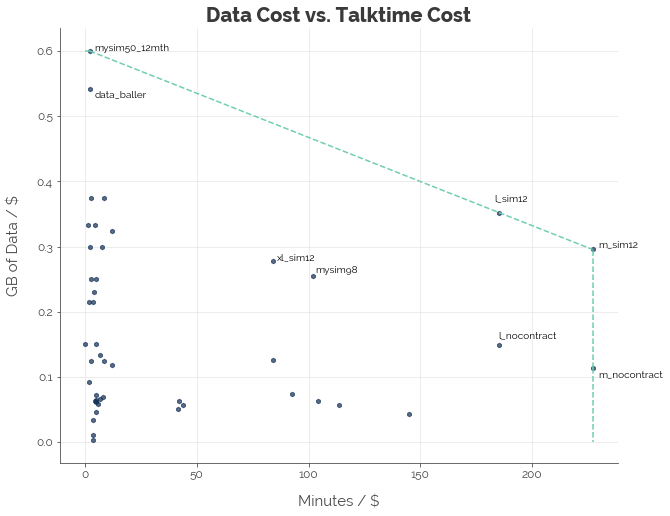

In [13]:
# Extract efficiencies
eff_data = df_graph[['talktime_cost', 'data_cost']].copy()

# Compute convex hull
hull = ConvexHull(eff_data)

# CODE FOR CUSTOM GRAPHICS NOT INCLUDED

The first thing we notice is the concentration of points on the far left of the graph. That's because the Telcos are competing primarily using data bundles. Along that dimension, M1 takes the top spot with its mySim 50 plan, which offers a whopping 30 GB. The second thing we notice is that Starhub is out there with 4 plans (M and L, 12-month and no-contract) owning the market segment focused on talktime - it has no close competitor.  
  
I've added labels for several other points that do not lie on the efficient frontier. Two of them are worth noting: Starhub's XL SIM-only plan and M1's mySim 98. I highlighted them because they offer a good balance between data and talktime.

## Bundle Plans
I don't actually know what the alternative to SIM-only plans are called. Hence, I'll just call them bundle plans since the underlying marketing tactic is essentially bundling (of phones and mobile services).

In [14]:
# Extract relevant data
df = mobile[['price', 'talktime', 'data']][mobile.sim_only == False]
df = df / df.mean()

# Configure inputs and outputs
df_inputs = df[['price']]
df_outputs = df[['talktime', 'data']]

# Data for graphics
df_graph = mobile[['price', 'talktime', 'data']][mobile.sim_only == False]
df_graph['talktime_cost'] = df_graph.talktime / df_graph.price
df_graph['data_cost'] = df_graph.data / df_graph.price

# Configure problem
mobile_prob = pydea.DEAProblem(df_inputs, df_outputs, returns = 'CRS')

# Solve problem
results = mobile_prob.solve()

# Attach results
dea_data = mobile[['name', 'provider', 'price', 'talktime', 'data']].copy()
dea_data['efficiency'] = round(results['Efficiency'], 3)

# Sort by efficiency
dea_data.sorted = dea_data.sort_values(by = ['efficiency', 'price', 'data'], ascending = [False, True, False])
dea_data.sorted = dea_data.sorted.reset_index(drop = True)

# View data
dea_data.sorted.head(5)

name provider  price  talktime    data  efficiency
0      combo3  singtel   68.9     10000     3.0       1.000
1  mysim_e118       m1  118.0     10000  1000.0       1.000
2           m  starhub   88.0     10000     5.0       0.784
3      combo6  singtel   95.9     10000     6.0       0.720
4           l  starhub  108.0     10000     8.0       0.640

Once again, M1 is spoiling the market with a beast of a plan: mySim(e) 118 with unlimited data.

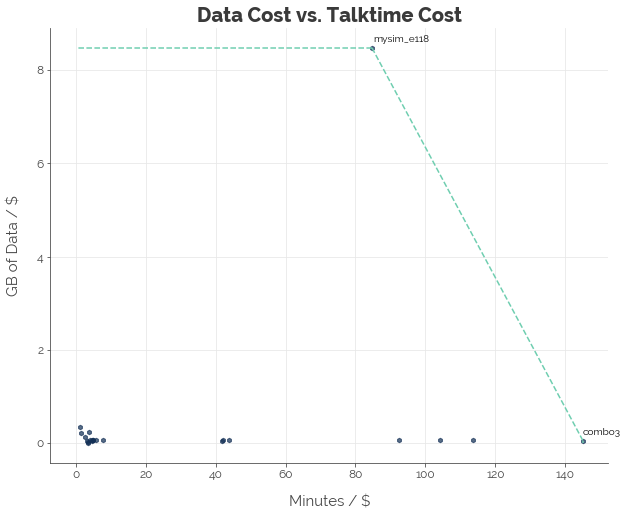

In [15]:
# Extract efficiencies
eff_data = df_graph[['talktime_cost', 'data_cost']].copy()

# Compute convex hull
hull = ConvexHull(eff_data)

# CODE FOR CUSTOM GRAPHICS NOT INCLUDED

## Bundle Plans, Less M1's Unlimited Data Plan
Removing M1's unlimited data plan, we get a better picture of how the rest of the bundle plans fare: 

In [16]:
# Extract relevant data
df = mobile[['price', 'talktime', 'data']][mobile.sim_only == False]
df = df.drop(38, axis = 0)
df = df / df.mean()

# Configure inputs and outputs
df_inputs = df[['price']]
df_outputs = df[['talktime', 'data']]

# Data for graphics
df_graph = mobile[['price', 'talktime', 'data']][mobile.sim_only == False]
df_graph = df_graph.drop(38, axis = 0)
df_graph['talktime_cost'] = df_graph.talktime / df_graph.price
df_graph['data_cost'] = df_graph.data / df_graph.price

# Configure problem
mobile_prob = pydea.DEAProblem(df_inputs, df_outputs, returns = 'CRS')

# Solve problem
results = mobile_prob.solve()

# Attach results
dea_data = mobile[['name', 'provider', 'price', 'talktime', 'data']].copy()
dea_data['efficiency'] = round(results['Efficiency'], 3)

# Sort by efficiency
dea_data.sorted = dea_data.sort_values(by = ['efficiency', 'price', 'data'], ascending = [False, True, False])
dea_data.sorted = dea_data.sorted.reset_index(drop = True)

# View data
dea_data.sorted.head(7)

name provider  price  talktime  data  efficiency
0     combo3  singtel   68.9     10000   3.0       1.000
1  mysim_e90       m1   90.0       100  30.0       1.000
2          m  starhub   88.0     10000   5.0       0.851
3     combo6  singtel   95.9     10000   6.0       0.812
4          l  starhub  108.0     10000   8.0       0.776
5    comboxo  singtel   78.0       300  18.0       0.711
6  mysim_e70       m1   70.0       100  15.0       0.647

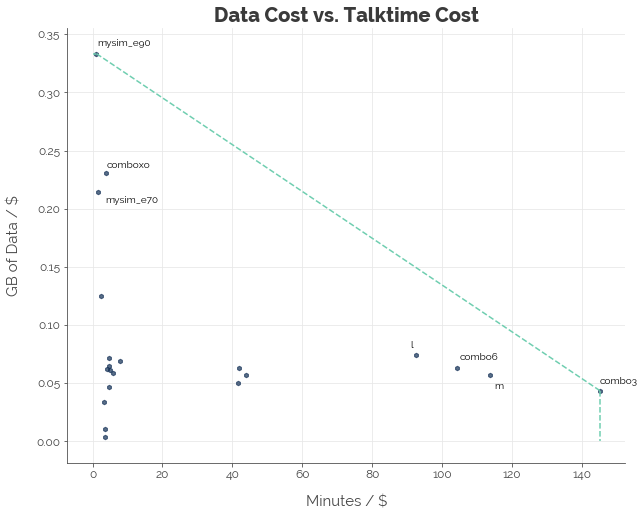

In [17]:
# Extract efficiencies
eff_data = df_graph[['talktime_cost', 'data_cost']].copy()

# Compute convex hull
hull = ConvexHull(eff_data)

# CODE FOR CUSTOM GRAPHICS NOT INCLUDED

We see that M1 offers 2 of the most value-for-money data plans, while Singtel offers the best talktime plan. Although Starhub provides the most value in the SIM-only market for talktime, Singtel takes top spot for bundle plans.

# Conclusion
In this post, I used linear regression to quantify the relationship between mobile plan parameters and their price, a decision tree to identify the most important parameters, and data envelopment analysis (DEA) to compute the most efficient plans for data and talktime, and the optimal tradeoff between these two priorities.  
  
As you can see from the variety of plans, the offering is extremely polarised. Plans deliver value either in terms of talktime or data. Thus, you only need to know your priority and your budget to make a good decision.  
  
## Data
If your priority is data, you only need to calculate the most efficient data plans based on data per dollar. Here are the top 5 from the SIM-only and bundle categories. M1 has an excellent offering in both categories.

In [18]:
# Extract top data plans
data_plans = mobile.copy()

# Calculate efficiency
data_plans['data_cost'] = data_plans.data / data_plans.price

# Sort plans
data_plans = data_plans.sort_values(by = ['sim_only', 'data_cost'], ascending = [False, False]).groupby('sim_only').head(5)
data_plans = data_plans.reset_index(drop = True)

# View
data_plans

name  price  talktime    sms    data      provider  contract  \
0  mysim98_12mth   98.0     10000  10000  1000.0            m1        12   
1  mysim50_12mth   50.0       100    100    30.0            m1        12   
2    data_baller   48.0       100      0    26.0  circles_life         0   
3       xs_sim12   24.0       200      0     9.0       starhub        12   
4  mysim40_12mth   40.0       100    100    15.0            m1        12   
5     mysim_e118  118.0     10000  10000  1000.0            m1        24   
6      mysim_e90   90.0       100    100    30.0            m1        24   
7        comboxo   78.0       300    300    18.0       singtel        24   
8      mysim_e70   70.0       100    100    15.0            m1        24   
9      mysim_e40   40.0       100    100     5.0            m1        24   

  sim_only  data_cost  
0     True  10.204082  
1     True   0.600000  
2     True   0.541667  
3     True   0.375000  
4     True   0.375000  
5    False   8.474576  
6    False   0.333333  
7    False   0.230769  
8    False   0.214286  
9    False   0.125000

## Talktime
If talktime is your priority, the decision is easy. There are many plans with unlimited talktime. It is therefore only a matter of price, and Starhub provides the best offers.

In [19]:
# Extract top plans
tt_plans = mobile.iloc[[5, 6, 8, 9, 11, 12, 13, 16, 17, 24, 25, 29, 30, 34, 36, 37, 38, 45], ].copy()
tt_plans = mobile.copy()

# Calculate efficiency
tt_plans['talktime_cost'] = tt_plans.talktime / tt_plans.price

# Sort plans
tt_plans = tt_plans.sort_values(by = ['sim_only', 'talktime_cost'], ascending = [False, False]).groupby('sim_only').head(5)
tt_plans = tt_plans.reset_index(drop = True)

# View
tt_plans

name  price  talktime    sms    data provider  contract sim_only  \
0        m_sim12   44.0     10000      0    13.0  starhub        12     True   
1   m_nocontract   44.0     10000      0     5.0  starhub         0     True   
2        l_sim12   54.0     10000      0    19.0  starhub        12     True   
3   l_nocontract   54.0     10000      0     8.0  starhub         0     True   
4  mysim98_12mth   98.0     10000  10000  1000.0       m1        12     True   
5         combo3   68.9     10000  10000     3.0  singtel        24    False   
6              m   88.0     10000      0     5.0  starhub        24    False   
7         combo6   95.9     10000  10000     6.0  singtel        24    False   
8              l  108.0     10000      0     8.0  starhub        24    False   
9     mysim_e118  118.0     10000  10000  1000.0       m1        24    False   

   talktime_cost  
0     227.272727  
1     227.272727  
2     185.185185  
3     185.185185  
4     102.040816  
5     145.137881  
6     113.636364  
7     104.275287  
8      92.592593  
9      84.745763

## Data and Talktime
If it is a combination of data and talktime you seek, use the table below to pick a plan. These are the most efficient plans on offer.

In [20]:
# Extract sim_only
names = mobile.sim_only.copy()
names.index = mobile.name

# Map sim_only
top_plans['sim_only'] = top_plans.name.map(names)

# Sort plans
top_plans = top_plans.sort_values(by = 'efficiency', ascending = False)
top_plans = top_plans.reset_index(drop = True)

# View table
top_plans.head(20)

name provider  price  talktime    data  efficiency sim_only
0         m_sim12  starhub   44.0     10000    13.0       1.000     True
1    m_nocontract  starhub   44.0     10000     5.0       1.000     True
2   mysim98_12mth       m1   98.0     10000  1000.0       1.000     True
3      mysim_e118       m1  118.0     10000  1000.0       0.831    False
4         l_sim12  starhub   54.0     10000    19.0       0.821     True
5    l_nocontract  starhub   54.0     10000     8.0       0.815     True
6          combo3  singtel   68.9     10000     3.0       0.639    False
7               m  starhub   88.0     10000     5.0       0.500    False
8          combo6  singtel   95.9     10000     6.0       0.459    False
9         mysim98       m1   98.0     10000    25.0       0.456     True
10              l  starhub  108.0     10000     8.0       0.407    False
11       xl_sim12  starhub  119.0     10000    33.0       0.379     True
12  xl_nocontract  starhub  119.0     10000    15.0       0.371     True
13       max_plus       m1  228.0     10000    13.0       0.193    False
14             xl  starhub  238.0     10000    15.0       0.185    False
15        combo12  singtel  239.9     10000    12.0       0.183    False
16        s_sim12  starhub   34.0       400    11.0       0.069     True
17  mysim50_12mth       m1   50.0       100    30.0       0.059     True
18       xs_sim12  starhub   24.0       200     9.0       0.057     True
19   s_nocontract  starhub   34.0       400     4.0       0.057     True